# SPA J=0 to J=1

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import psutil
import datetime


from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, signal
from astropy import units
import tqdm
import polars as pl
from tqdm.notebook import tqdm as tqdm_notebook

from centrex_tlf import states, couplings, utils
from centrex_tlf.states import UncoupledBasisState, UncoupledState, ElectronicState
from state_prep.utils import calculate_transition_frequency
from state_prep.electric_fields import (
    ElectricField,
    Ez_from_csv,
)
from state_prep.hamiltonians import SlowHamiltonian
from state_prep.intensity_profiles import GaussianBeam, BackgroundField
from state_prep.magnetic_fields import MagneticField
from state_prep.microwaves import Polarization, MicrowaveField
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory


In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
cwd = Path().cwd().absolute()
path_data = cwd / "results"


In [4]:
nr_cores = psutil.cpu_count(logical=False) + 2

rng = np.random.default_rng()


## Define molecule trajectory
Defining the molecule trajectory as a Trajectory object. Specifying the initial position as z = 50 mm, i.e. 50mm  after the center of the microwaves is, and on the axis of the beamline. Taking the beam velocity to be 200 m/s in the z-direction. The simulation ends when `zfin` is reached, 200 mm from the microwwaves.

In [5]:
trajectory = Trajectory(
    Rini=np.array((0, 0, -80e-3)), Vini=np.array((0, 0, 200.0)), zfin=200e-3
)

## Define electric field
Defining an electric field that is an approximation of what the molecules should see in the real experiment.

In [6]:
# Define electric field based on finite element simulations
Ez = Ez_from_csv()
E_R = lambda R: np.array([0, 0, Ez(R[2])])


electric_field = ElectricField(E_R, trajectory.R_t)

Max electric field: 263.46 V/cm
Electric field at z = 0: 172.39 V/cm
Electric field at z = 1.125'': 109.24 V/cm


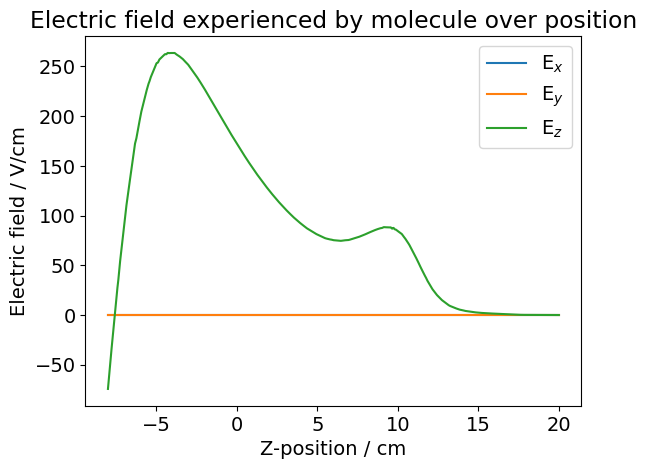

In [9]:
# Plot the electric field as a check:
ts, Es, ax = electric_field.plot(trajectory, position=True)

print(f"Max electric field: {np.max(Es):.2f} V/cm")
print(f"Electric field at z = 0: {E_R(np.array([0, 0, 0]))[2]:.2f} V/cm")
print(
    f"Electric field at z = 1.125'': {E_R(np.array([0, 0, 0.0254 * 1.125]))[2]:.2f} V/cm"
)

## Define magnetic field
Define the magnetic field. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [10]:
B = np.array((0, 0, 1e-3))


# B = np.array((0.2,0.45,0.1))
def B_R(R):
    if len(R.shape) == 1:
        return B
    else:
        return B.reshape((3, 1)) * np.ones(R.shape)


magnetic_field = MagneticField(B_R, R_t=trajectory.R_t)

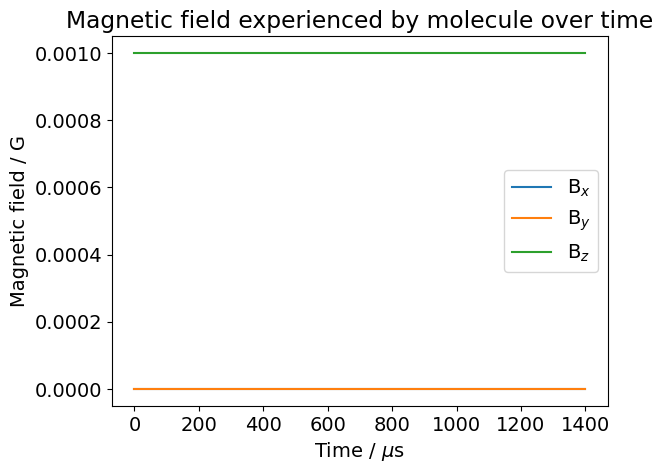

In [11]:
magnetic_field.plot(trajectory)

## Initial and final states
Define approximate initial states here.

In [12]:
# Define some useful approximate states
J0_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=+1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        - 1
        * UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=+1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J0_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=+1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        + 1
        * UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=+1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J0_triplet_p = 1 * UncoupledBasisState(
    J=0,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=+1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

J0_triplet_m = 1 * UncoupledBasisState(
    J=0,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=+1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

initial_states_approx = [J0_singlet, J0_triplet_m, J0_triplet_0, J0_triplet_p]

In [13]:
# Define some useful approximate states
J1_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=-1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        - 1
        * UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=-1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J1_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=-1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
        + 1
        * UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=-1,
            Omega=0,
            electronic_state=ElectronicState.X,
        )
    )
)

J1_triplet_p = 1 * UncoupledBasisState(
    J=1,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=-1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

J1_triplet_m = 1 * UncoupledBasisState(
    J=1,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=-1,
    Omega=0,
    electronic_state=ElectronicState.X,
)

# initial_states_approx = [J1_singlet, J1_triplet_m, J1_triplet_0, J1_triplet_p]

## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 0 and 1 states; J = 0 and 3 are absolutely required since the electric field couples J = 0 to these, J = 3 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [15]:
Js = [0, 1, 2, 3]
hamiltonian = SlowHamiltonian(Js, trajectory, electric_field, magnetic_field)

## Define microwave Hamiltonian
We will define a microwave field with the following properties
- A Gaussian spatial profile with 1'' intensity FWHM (cylindrically symmetric) 
- propagating along the X-direction
- polarized along the Z-direction
- Calculate power based on the desired Rabi rate for the desired transition

In [16]:
# Define states
state1 = J0_triplet_0
state2 = J1_triplet_0

# Center position
R0 = np.array((0.00, 0, -0.0))

#### Polarization:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
p_main = p_z
P_R = lambda R: p_main / np.sqrt(np.sum(p_main**2))

# Define k-vector
k = np.array((1, 0, 0))
pol = Polarization(P_R, k, f_long=1)

#### Frequency
# Calculate the microwave frequency between specified states at a specific point
detuning_1 = 0e6
muW_freq_1 = (
    calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
    + detuning_1
)
print(f"Transition frequency at center of SPA1 microwaves: {muW_freq_1 / 1e9:.5f} GHz")

#### Intensity profile:
# Define a Gaussian intensity profile
# intensity = MeasuredBeam(power = 1e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq)
intensity = GaussianBeam(
    power=0.5e-3,
    sigma=1 * 25.4e-3 / (2 * np.sqrt(2 * np.log(2))),
    R0=R0,
    k=k,
    freq=muW_freq_1,
)

#### Define MicrowaveField
mf01 = MicrowaveField(0, 1, intensity, pol, muW_freq_1, hamiltonian.QN)

Transition frequency at center of SPA1 microwaves: 13.34005 GHz


## Time-evolution
Next define a Simulator and use it to numerically integrate the Schroedinger equation to see how the states evolve as the electric field is ramped down. 

In [36]:
initial_states_approx = [J0_singlet, J0_triplet_m, J0_triplet_0, J0_triplet_p]

In [37]:
# Set microwave parameters
## Center postion
R0 = np.array([0.0, 0.0, 0.0])

## Sigma
mf01.intensity.sigma = 1.0 * 25.4e-3 / (2 * np.sqrt(2 * np.log(2)))

## Frequency
freq = calculate_transition_frequency(
    state1, state2, hamiltonian.H_R(R0), hamiltonian.QN
)
detuning = 0e6
mf01.set_frequency(freq + detuning)
mf01.set_frequency(freq + detuning)
mf01.set_position(R0)

## Power
mf01.set_power(5e-5)

# Molecule parameters
trajectory.Rini = np.array([0, 0.00, -80e-3])
trajectory.Vini = np.array([0, 0, 184])

In [38]:
microwave_fields = [mf01]

simulator = Simulator(
    trajectory,
    electric_field,
    magnetic_field,
    initial_states_approx,
    hamiltonian,
    microwave_fields,
)

In [39]:
result = simulator.run(N_steps=10000)

100%|██████████| 9999/9999 [00:49<00:00, 200.96it/s]


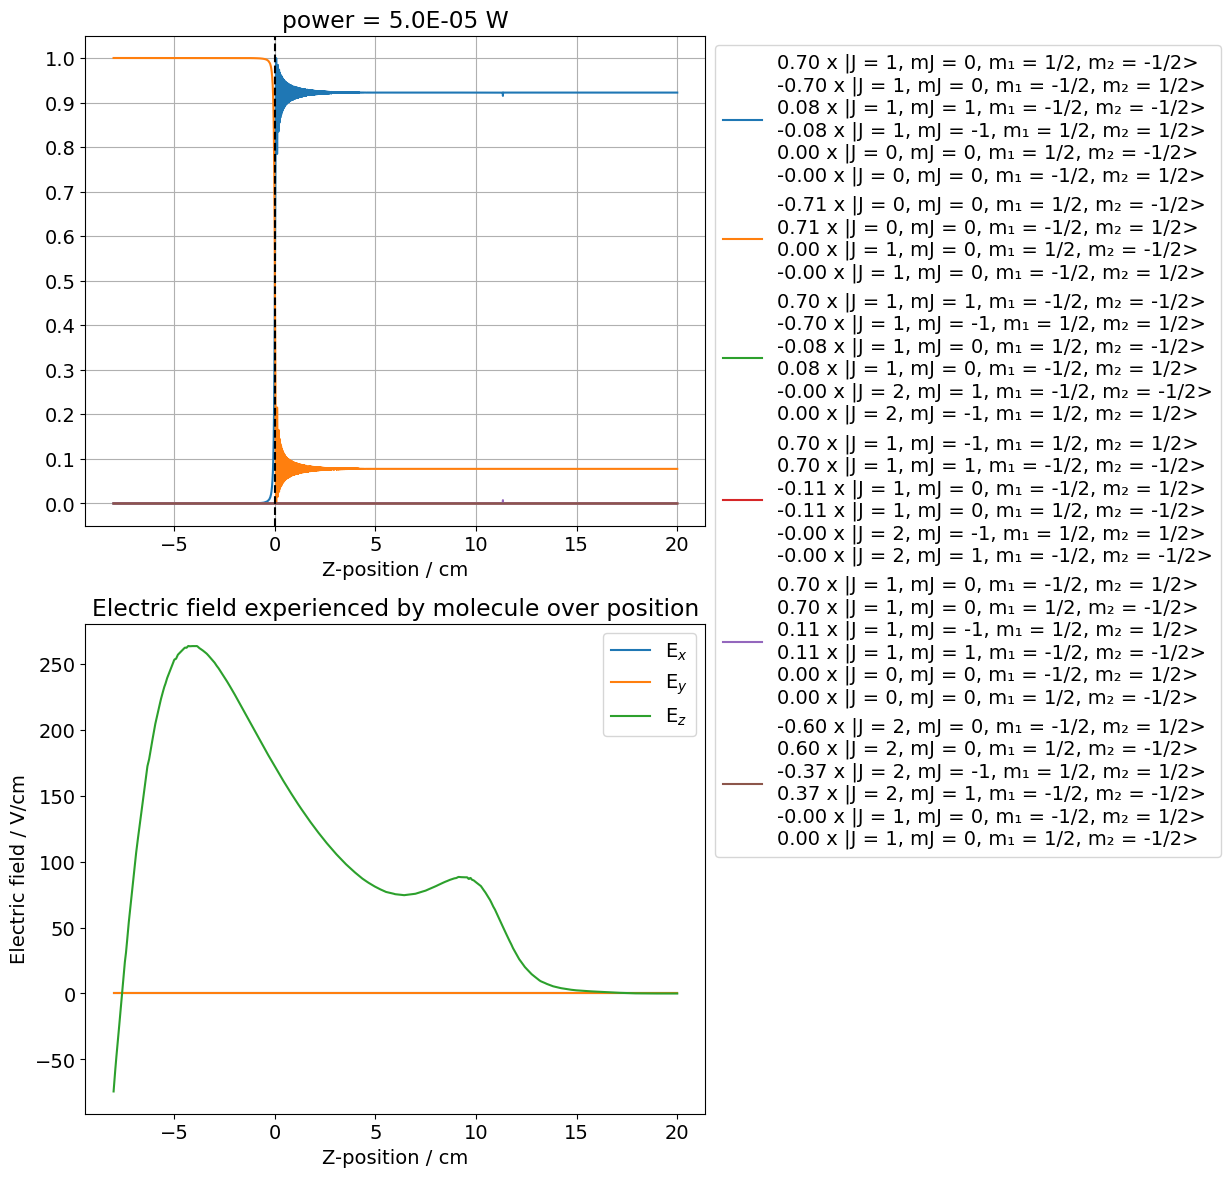

In [40]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N=6)
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 14))
result.plot_state_probabilities(large_prob_states, initial_state, ax=ax, position=True)
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.legend(fontsize=14, bbox_to_anchor=(1.0, 1))
ax.axvline(x=R0[2] * 1e2, ls="--", c="k")
ax.set_title(f"power = {mf01.intensity.power:.1E} W")
ax.grid()

_ = electric_field.plot(trajectory, position=True, ax=ax2)


# Scan Frequency and Power

In [41]:
# Define states
state1 = J0_triplet_0
state2 = J1_triplet_0

# Center position
R0 = np.array((0.00, 0, -0.0))

#### Polarization:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
p_main = p_z
P_R = lambda R: p_main / np.sqrt(np.sum(p_main**2))

# Define k-vector
k = np.array((1, 0, 0))
pol = Polarization(P_R, k, f_long=1)

#### Frequency
# Calculate the microwave frequency between specified states at a specific point
detuning_1 = 0e6
muW_freq_1 = (
    calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
    + detuning_1
)

#### Intensity profile:
# Define a Gaussian intensity profile
# intensity = MeasuredBeam(power = 1e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq)
intensity = GaussianBeam(
    power=0.5e-3,
    sigma=1 * 25.4e-3 / (2 * np.sqrt(2 * np.log(2))),
    R0=R0,
    k=k,
    freq=muW_freq_1,
)

#### Define MicrowaveField
mf01 = MicrowaveField(0, 1, intensity, pol, muW_freq_1, hamiltonian.QN)

In [42]:
def run_simulation(
    power_spa1: float,
    freq_spa1: float,
    v_forward: float,
    initial_state_idx: int,
    target_state: states.UncoupledState | list[states.UncoupledState],
    monitor_states: list[states.UncoupledState] = [],
    N_steps=10_000,
) -> tuple[float, float, float, float, float, list[float]]:
    """
    Runs the simulation for one value of power and finds the probability of ending up in the target state.
    """

    mf01.set_frequency(freq_spa1)

    # set powers & intensities
    mf01.set_power(power_spa1)

    # Run the simulator
    microwave_fields = [mf01]

    # # trajectories
    trajectory.Vini[-1] = v_forward

    # pickle problem occurs here
    simulator = Simulator(
        trajectory,
        electric_field,
        magnetic_field,
        initial_states_approx,
        hamiltonian,
        microwave_fields,
    )

    result = simulator.run(N_steps=N_steps)

    # Determine probability to be in initial state
    prob_ini = float(
        result.get_state_probability(
            result.initial_states[initial_state_idx],
            initial_state=result.initial_states[initial_state_idx],
        )[-1]
    )

    # Determine probability to be in target state
    if isinstance(target_state, states.UncoupledState):
        target_state = [target_state]
    prob_fin = 0.0
    for ts in target_state:
        prob_fin += float(
            result.get_state_probability(
                ts, initial_state=result.initial_states[initial_state_idx]
            )[-1]
        )

    prob_monitor_states = []
    for monitor_state in monitor_states:
        prob_monitor_states.append(
            float(
                result.get_state_probability(
                    monitor_state,
                    initial_state=result.initial_states[initial_state_idx],
                )[-1]
            )
        )

    return (power_spa1, freq_spa1, v_forward, prob_ini, prob_fin, prob_monitor_states)


In [52]:
detunings = np.linspace(-5e6, 7e6, 21)
powers_dBm = np.linspace(-30, 10, 10)  # 10 steps
powers_W = 10 ** ((powers_dBm - 30) / 10)

res = [
    Parallel(n_jobs=nr_cores, verbose=1)(
        delayed(run_simulation)(
            power_spa1=power,
            freq_spa1=detuning + muW_freq_1,
            v_forward=184.0,
            initial_state_idx=2,  # J1_triplet_0
            target_state=J1_triplet_0,
            monitor_states=[],
        )
        for detuning in detunings
    )
    for power in powers_W
]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [53]:
data = np.array([[r[-3:-1] for r in re] for re in res])

fig, ax = plt.subplots()

ax.plot(detunings / 1e6, data[:, 1], lw=2)

ax.grid()

TypeError: 'float' object is not subscriptable

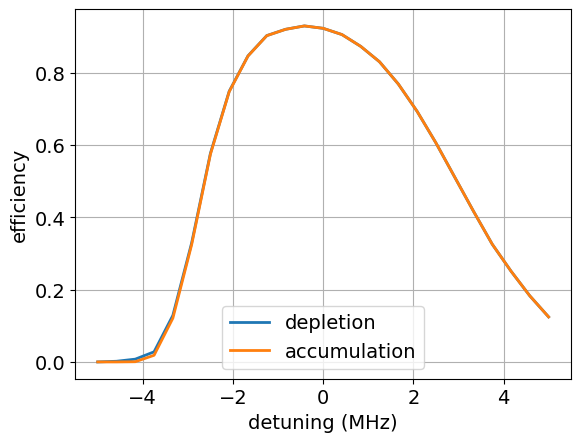

In [44]:
fig, ax = plt.subplots()

ax.plot(detunings / 1e6, [1 - r[-3] for r in res], lw=2, label="depletion")
ax.plot(detunings / 1e6, [r[-2] for r in res], lw=2, label="accumulation")

ax.set_xlabel("detuning (MHz)")
ax.set_ylabel("efficiency")

ax.legend()
ax.grid()